### Duolingo Exploratory Analysis

####  Duolingo is an American educational technology company that produces learning apps and provides language certification. There main app is considered the most popular language learning app in the world.

##### To progress in their learning journey, each user of the application needs to complete a set of lessons in which they are presented with the words of the language they want to learn. In an infinite set of lessons, each word is applied in a different context and, on top of that, Duolingo uses a spaced repetition approach, where the user sees an already known word again to reinforce their learning.

##### Each line in this file refers to a Duolingo lesson that had a target word to practice. This notebook aims to explore the content of Duolingo Dataset, a file containing 13 million Duolingo student learning traces.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

##### Basic information about the dataset:
We have 12 columns in the dataset, as it follows:

- timestamp, delta, user_id: Identifiers (for user and for the practiced word) and other one is the timestamp indicating when the practice happened.
- learning_language, ui_language: We have the indication of the learning language and of the interface language (presumably native to the student).
- lexeme_id, lexeme_string: We also have the word practiced with some gramatical details as the inflected and the uninflected form seen in (or intended for) the exercise, the part of speech and each of the modifers (tense, gender, person, case, etc.).
- history_seen, history_correct, session_seen, session_correct: We have the total times user has seen the word, total times user has been correct for the word, times the user saw the word during the specific lesson, times the user got the word correct during this specific lesson and the time (in seconds) since the last lesson that included this word.

In [3]:
# Load the data
duolingo_users = pd.read_csv('learning_traces.13m.csv')
duolingo_users.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


##### I will do the Exploratory Data Analysis with a sample of 2 million sessions.

In [4]:
# Take 2 million random rows
duolingo_users_reduced = duolingo_users.sample(n=2000000, random_state=42)  # random_state for reproducibility

# Save the reduced dataset
duolingo_users_reduced.to_csv('duolingo_users_reduced.csv', index=False)

In [5]:
# Print the shape of the reduced dataset
print(duolingo_users_reduced.shape[0])
print(duolingo_users_reduced.shape[1])

2000000
12


In [6]:
# Print the info of the reduced dataset
duolingo_users_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 7029480 to 2799315
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   p_recall           float64
 1   timestamp          int64  
 2   delta              int64  
 3   user_id            object 
 4   learning_language  object 
 5   ui_language        object 
 6   lexeme_id          object 
 7   lexeme_string      object 
 8   history_seen       int64  
 9   history_correct    int64  
 10  session_seen       int64  
 11  session_correct    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 198.4+ MB


In [7]:
# Convert the timestamp column to datetime
duolingo_users_reduced['timestamp'] = pd.to_datetime(duolingo_users_reduced['timestamp'],unit='s')

##### Missing values.

In [8]:
# Check for missing values
duolingo_users_reduced.isnull().sum()

p_recall             0
timestamp            0
delta                0
user_id              0
learning_language    0
ui_language          0
lexeme_id            0
lexeme_string        0
history_seen         0
history_correct      0
session_seen         0
session_correct      0
dtype: int64

##### Duplicates.

In [9]:
# Check for duplicates in all columns
print(duolingo_users_reduced.duplicated(subset=None).sum())

0


In [10]:
# Check frame of period of time
duolingo_users_reduced['timestamp'].describe()

count                          2000000
mean     2013-03-06 17:05:33.095878656
min                2013-02-28 18:28:01
25%                2013-03-03 20:31:36
50%                2013-03-06 17:42:08
75%                2013-03-09 16:21:27
max                2013-03-12 16:14:54
Name: timestamp, dtype: object

***

##### Exploratory Data Analysis.

In [11]:
# Check unique users with unique lexemes
print('We have {} unique users learning {} different lexemes.'.format(duolingo_users_reduced.user_id.nunique(), duolingo_users_reduced.lexeme_id.nunique()))

We have 100242 unique users learning 14930 different lexemes.


In [12]:
print('The general correct rate of the dataset is {:.2f}%.'.format(100*duolingo_users_reduced['session_correct'].sum()/duolingo_users_reduced['session_seen'].sum()))

The general correct rate of the dataset is 90.46%.


##### Duolingo encourages its users to achieve a perfect practice mark, I analyze the perfection rate.

In [13]:
duolingo_users_reduced['session_perfect'] = (duolingo_users_reduced['session_correct'] == duolingo_users_reduced['session_seen'])
print('The general perfection rate of the dataset is {:.2f}%.'.format(100*duolingo_users_reduced['session_perfect'].sum()/duolingo_users_reduced['session_perfect'].count()))

The general perfection rate of the dataset is 83.91%.


##### Most frequently learned languages

In [14]:
# Check the unique learning languages
duolingo_users_reduced['learning_language'].unique()

array(['en', 'fr', 'de', 'pt', 'es', 'it'], dtype=object)

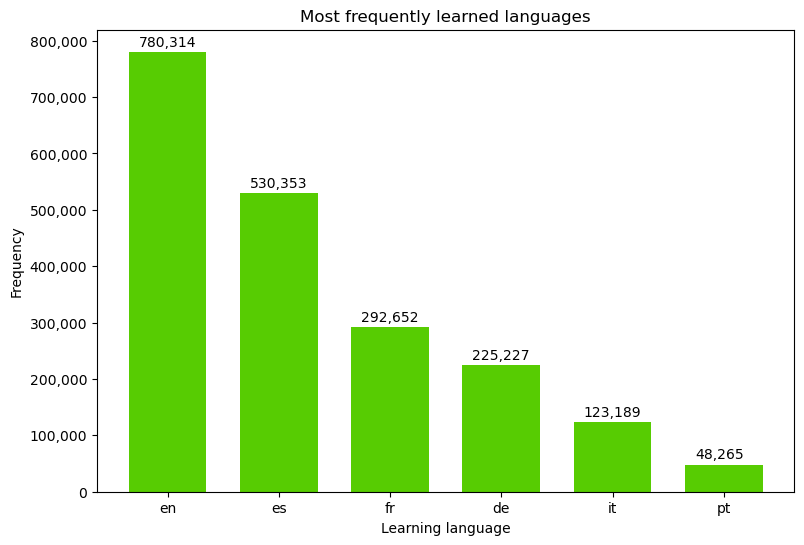

In [15]:
# Plot the most frequently learned languages
plt.figure(figsize=(9,6))

#Plotting the grouped dataframe with necessary fields for the chart
bar_plot = pd.DataFrame(duolingo_users_reduced['learning_language'].value_counts()).reset_index()
xis = [i for i in range(bar_plot['learning_language'].nunique())]
x1 = plt.bar(xis, bar_plot['count'], width = 0.7, color = '#57cc02')

#Better allocating the values shown in the bars
for i in range(len(xis)):
    if bar_plot['count'].iloc[i] > 999999:
        plt.text(x=xis[i]-0.32, y=bar_plot['count'].iloc[i]+10000, s='{:,}'.format(bar_plot['count'].iloc[i]), size=10)  # reduced from +55000 to +10000
    else:
        plt.text(x=xis[i]-0.26, y=bar_plot['count'].iloc[i]+10000, s='{:,}'.format(bar_plot['count'].iloc[i]), size=10)  # reduced from +55000 to +10000

#Fancy stuff
plt.title('Most frequently learned languages')
plt.xticks(xis, bar_plot['learning_language'].unique())
plt.ylabel('Frequency')
plt.xlabel('Learning language')

# Format y-axis with comma separator for better readability
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

##### Most difficult languages learned by english speakers

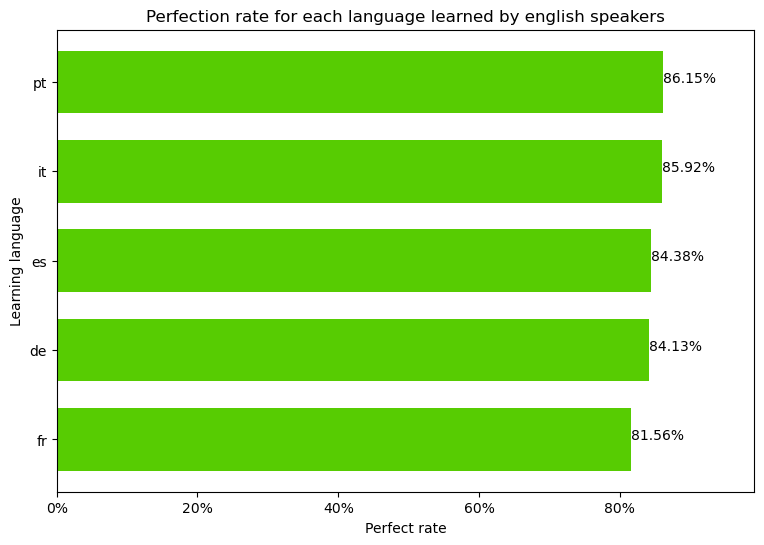

In [16]:
plt.figure(figsize=(9,6))

#Plotting the grouped dataframe with necessary fields for the chart
bar_plot = duolingo_users_reduced[duolingo_users_reduced['ui_language']=='en'][['learning_language', 'session_perfect']].copy()
bar_plot = bar_plot.groupby(by=['learning_language']).agg(['sum', 'count']).reset_index()
bar_plot.columns = ['learning_language', 'sum', 'count']
bar_plot['perfection_rate'] = bar_plot['sum']/bar_plot['count']
bar_plot.sort_values(by=['perfection_rate'], ascending=True, inplace=True)
xis = [i for i in range(bar_plot['learning_language'].nunique())]
x1 = plt.barh(xis, bar_plot['perfection_rate'], color = '#57cc02', label='correct percent', height=0.7)

#Better allocating the values shown in the bars
for i in range(len(xis)):
    plt.text(y=xis[i], x=bar_plot['perfection_rate'].iloc[i], s='{:.2f}'.format(100*bar_plot['perfection_rate'].iloc[i])+'%', size=10)

plt.title('Perfection rate for each language learned by english speakers')
plt.yticks(xis, bar_plot['learning_language'].unique())
plt.margins(x=.15)
plt.xlabel('Perfect rate')
plt.ylabel('Learning language')

# Optional: Format x-axis as percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0%}'.format(x)))

plt.show()

In [17]:
# Extract indexed information from the lexeme_id
aux_list = list()
for part in duolingo_users_reduced['lexeme_string'].values:
    if 'prn>' in part:
        aux_list.append('pronoun')
    elif 'n>' in part:
        aux_list.append('noun')
    elif 'det>' in part:
        aux_list.append('determinative')
    elif 'adj>' in part:
        aux_list.append('adjective')
    elif 'adv>' in part:
        aux_list.append('adverb')
    elif '<vb' in part:
        aux_list.append('verb')
    elif 'ij>' in part:
        aux_list.append('interjection')
    elif 'pr>' in part:
        aux_list.append('preposition')
    elif 'cnjcoo>' in part:
        aux_list.append('conjunction')
    elif 'num>' in part:
        aux_list.append('number')
    else:
        aux_list.append('n/a')
        
duolingo_users_reduced['gramatical_part'] = aux_list

##### Most challenging grammatical parts

In [18]:
# Print the first 5 rows of the new column
duolingo_users_reduced['gramatical_part'].head()

7029480              noun
3432519           pronoun
10564558        adjective
3236614     determinative
1351419              verb
Name: gramatical_part, dtype: object

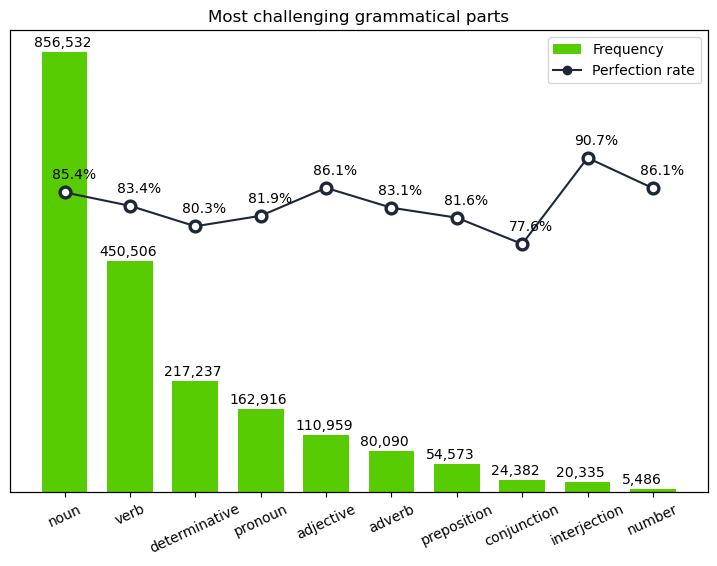

In [19]:
fig, x1 = plt.subplots(figsize=(9,6))

#Defining the grouped dataframe with necessary fields for the chart
bar_plot = duolingo_users_reduced[duolingo_users_reduced['gramatical_part']!='n/a'][['gramatical_part', 'session_perfect']].copy()
bar_plot = bar_plot.groupby(by=['gramatical_part']).agg(['sum', 'count']).reset_index()
bar_plot.columns = ['gramatical_part', 'sum', 'count']
bar_plot['perfection_rate'] = bar_plot['sum']/bar_plot['count']
bar_plot.sort_values(by=['count'], ascending=False, inplace=True)

#Plotting bars and lines
xis = [i for i in range(bar_plot['gramatical_part'].nunique())]
x1.bar(xis, bar_plot['count'], color = '#57cc02', label='Frequency', width=0.7)
x2 = x1.twinx()
x2.plot(xis, bar_plot['perfection_rate'], color = '#1e263a', label='Perfection rate', marker='o')
x2.scatter(xis, bar_plot['perfection_rate'], fc="w", ec="#1e263a", s=60, lw=2.4, zorder=12) 
#Better allocating the values shown in the bars and the lines
for i in range(len(xis)):
    y_value = bar_plot['perfection_rate'].iloc[i]
    y_other_value = bar_plot['count'].iloc[i]
    x2.text(x=xis[i]-0.2, y=y_value+0.02, s='{:.1f}'.format(100*y_value)+'%', size=10)
    if bar_plot['count'].iloc[i] > 999999:
        x1.text(x=xis[i]-0.6, y=y_other_value+10000, s='{:,}'.format(y_other_value), size=10)
    else:
        x1.text(x=xis[i]-0.475, y=y_other_value+10000, s='{:,}'.format(y_other_value), size=10)

#Fancy stuff
x1.set_yticks([])
x2.set_yticks([])
x2.set_ylim([0.40,1.1])
plt.title('Most challenging grammatical parts')
x1.set_xticks(xis, bar_plot['gramatical_part'].unique(), rotation=25)
lines_1, labels_1 = x1.get_legend_handles_labels()
lines_2, labels_2 = x2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
plt.legend(lines, labels, loc=0)
plt.show()

##### After analyzing the grammatical parts, nouns and verbs are the most frequent grammatical parts while interjections and numbers are the least. The difference between the frequency of practice with the two terms is enormous, users practice 154 times more nouns than numbers. The hardest part for users to learn are conjunctions and the easiest part is interjections.

In [20]:
# Feature engineering for the hour of the day
aux = {4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 10:7, 11:8, 12:9, 13:10, 14:11, 15:12, 16:13, 17:14, 18:15, 19:16, 20:17, 21:18, 22:19, 23:20, 24:21, 1:22, 2:23, 3:24}
duolingo_users_reduced['hour'] = duolingo_users_reduced['timestamp'].dt.hour
duolingo_users_reduced['hour_aux'] = duolingo_users_reduced['hour'].map(aux)
color = ['#e5f5e0', '#e5f5e0', '#e5f5e0', '#e5f5e0', '#e5f5e0', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#a1d99b', '#a1d99b', '#a1d99b', '#a1d99b', '#a1d99b', '#a1d99b', '#a1d99b', '#74c476', '#74c476', '#74c476', '#74c476', '#74c476'
        ]

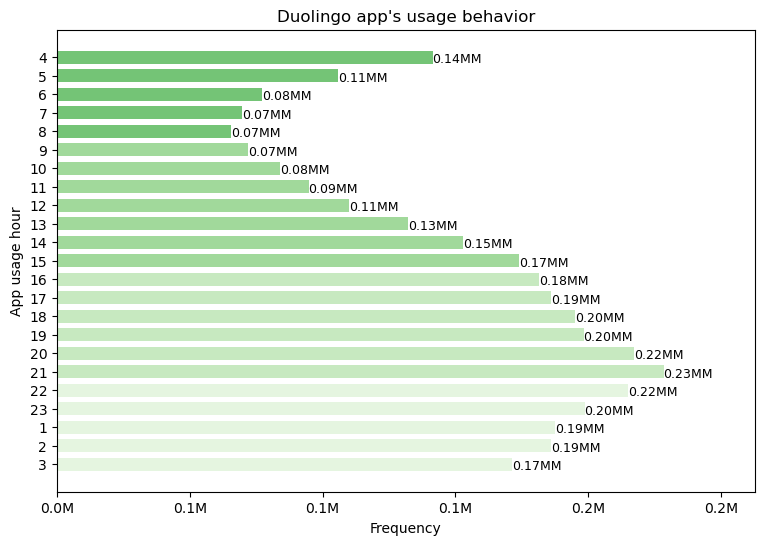

In [21]:
plt.figure(figsize=(9,6))

#Plotting the grouped dataframe with necessary fields for the chart
bar_plot = duolingo_users_reduced[['hour','hour_aux', 'session_seen']].groupby(by=['hour', 'hour_aux']).sum().reset_index()
bar_plot.sort_values(by=['hour_aux'], ascending=False, inplace=True)
xis = [i for i in range(bar_plot['hour'].nunique())]
x1 = plt.barh(xis, bar_plot['session_seen'], color = color, label='sessions seen', height=0.7)

#Better allocating the values shown in the bars
for i in range(len(xis)):
    x_value = bar_plot['session_seen'].iloc[i]
    plt.text(y=xis[i]-0.3, x=x_value, s='{:.2f}MM'.format((x_value)/1000000), size=9)

#Fancy stuff
# Remove this line to show x-axis ticks
# plt.xticks([])

plt.title("Duolingo app's usage behavior")
plt.yticks(xis, bar_plot['hour'].unique())
plt.margins(x=.15)
plt.ylabel('App usage hour')
plt.xlabel('Frequency')

# Optional: Format x-axis with millions
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.1f}M'.format(x/1000000)))

plt.show()

##### Analyze at what time of day users use the application most.

One of the strategies Duolingo uses are the "Missions". Basically, they are challenges that try to attack the main moments that could cause users to lose engagement. The idea is that if I can force you to wake up at 7 am to practice and you receive a reward for that effort, you will probably want to maintain this habit in the future.

I will separate the users' daily journey into four major moments:

- Critical (4am - 8am)
Users here are very little engaged, I recommend that we think about urgent strategies to reactivate this period.

- Growing slowly (9am-3pm)
We see an improvement in behavior, but we still need to further accelerate these users who are resuming their routine.

- More engaged (4pm-9pm)
These are the best and most engaged moments for users. We don't need to put any effort here. We want all users to reach this level of use.

- Losing interest (10pm-3am)

##### Consecutive days engagement

In [22]:
# Feature engineering for the day of the week
duolingo_users_reduced['date'] = duolingo_users_reduced['timestamp'].dt.date
duolingo_users_reduced.sort_values(by=['user_id', 'date'], ascending=False, inplace=True)
df_aux = duolingo_users_reduced[['user_id', 'date']].drop_duplicates()
df_aux['sequence_end'] = ~(df_aux['date'] + timedelta(days=1) == df_aux.groupby(['user_id'])['date'].shift(1))
df_aux['sequence_start'] = ~(df_aux['date'] - timedelta(days=1) == df_aux.groupby(['user_id'])['date'].shift(-1))

df_aux_2 = df_aux[df_aux['sequence_start']==True][['user_id', 'date']].reset_index(drop=True)
df_aux_2.columns = ['user_id', 'sequence_start'] 
df_aux_2['sequence_end'] = df_aux[df_aux['sequence_end']==True].reset_index()['date']
df_aux_2[['sequence_start', 'sequence_end']] = df_aux_2[['sequence_start', 'sequence_end']].apply(pd.to_datetime)
df_aux_2['sequence_length'] = (df_aux_2['sequence_end'] - df_aux_2['sequence_start']).dt.days + 1
df_aux_2.sort_values(by=['sequence_length'], inplace=True, ascending=False)

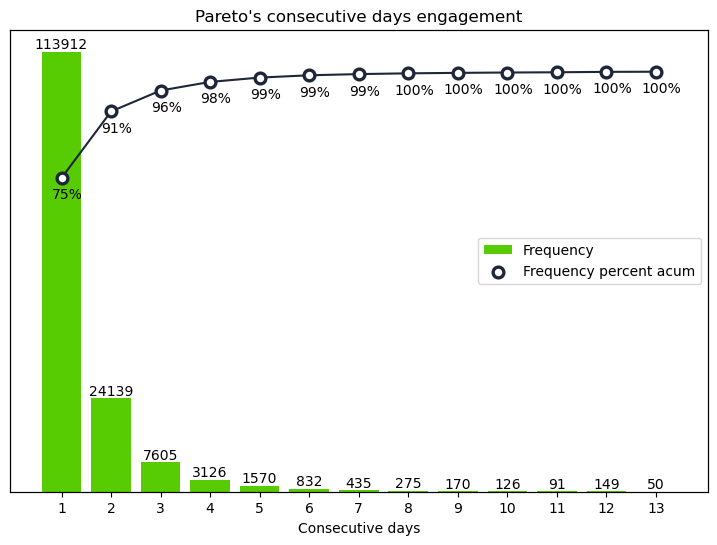

In [23]:
fig, ax = plt.subplots(figsize=(9,6))

#Defining the grouped dataframe with necessary fields for the chart
df_group = df_aux_2[['sequence_length', 'user_id']].groupby(by=['sequence_length']).count().reset_index()
df_group['cum_sum'] = df_group['user_id'].cumsum()
df_group['percent'] = df_group['cum_sum'] / df_group['user_id'].sum() * 100

#Plotting bars and lines
line0 = ax.bar(df_group['sequence_length'], df_group['user_id'], color="#57cc02", label='Frequency')
ax.set_title("Pareto's consecutive days engagement")
plt.xlabel('Consecutive days')
ax2 = ax.twinx()
line1 = ax2.plot(df_group['sequence_length'], df_group['percent'], color="#1e263a", ms=7, marker='o')
ax2.scatter(df_group['sequence_length'], df_group['percent'], 
            fc="w", ec="#1e263a", s=60, lw=2.4, zorder=12, label='Frequency percent acum') 

#Better allocating the values shown in the bars
rects = ax.patches
labels = df_group['sequence_length']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
    )

#Better allocating the values shown in the lines
line = ax2.lines[0]
for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
    label = "{:.0f}%".format(y_value)
    ax2.annotate(label,(x_value, y_value), xytext=(4, -15), 
        textcoords="offset points", ha='center')

#Fancy stuff
plt.xticks(df_group['sequence_length'])
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylim([0,110])
plt.yticks([])
line0, label0 = ax.get_legend_handles_labels()
line1, label1 = ax2.get_legend_handles_labels()
lines = line0 + line1
labels = label0 + label1
plt.legend(lines, labels, loc='center right')
plt.show()

##### This plot shows the distribution of consecutive days of engagement on what appears to be Duolingo, with two key metrics:
1. Green bars showing the frequency (number of users)
2. Black line with circles showing the cumulative percentage

Key observations:
1. Most users (111,912) only engage for 1 consecutive day
2. There's a sharp drop to 24,139 users for 2 consecutive days
3. The drop continues exponentially as the streak length increases
4. By day 3, only 7,605 users maintain their streak
5. Very few users (50) reach 13 consecutive days

The cumulative percentage line shows:
- 75% of users stop at day 1
- 91% of users stop by day 2
- 96% by day 3
- By day 7-8, it reaches nearly 100%

This pattern suggests:
- User retention is a significant challenge
- The first few days are critical for user engagement
- Very few users maintain long streaks
- There might be an opportunity to improve retention strategies, especially during the crucial first 3 days
- The platform might benefit from implementing features that encourage users to return after their first day

##### Days usage behavior

In [24]:
df_aux = duolingo_users_reduced[['user_id', 'date', 'timestamp']].groupby(by=['user_id', 'date']).nunique().reset_index()
df_aux.columns = ['user_id', 'date', 'count_lessons']
df_aux = df_aux[['date', 'count_lessons']].groupby(by='date').sum().reset_index()
df_aux.columns = ['date', 'count_lessons']

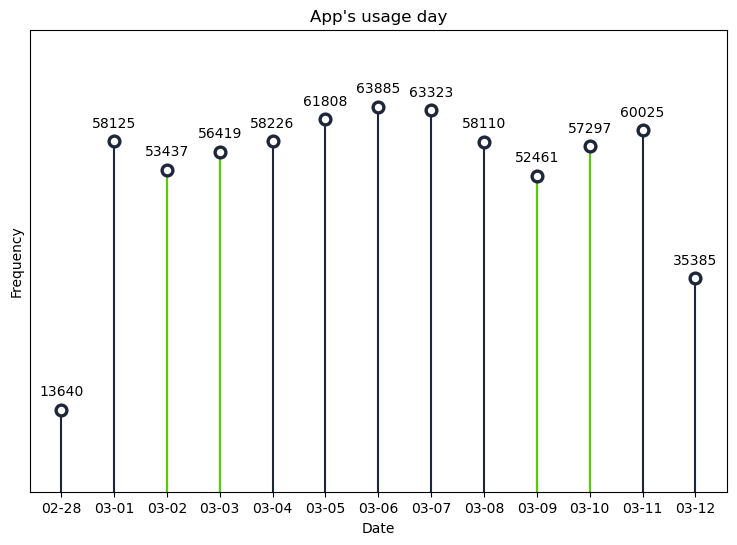

In [25]:
fig, ax = plt.subplots(figsize = (9, 6))

#Defining the grouped dataframe with necessary fields for the chart
x = df_aux['date']
y = df_aux['count_lessons']
ax.vlines(x, ymin=0, ymax=y, color='#1e263a')
ax.scatter(x, y, fc="w", ec="#1e263a", s=60, lw=2.4, zorder=12, label='ddd')
ax.plot(x,y, "o", color='#1e263a')

#Better allocating the values shown in the lines
line = ax.lines[0]
for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
    label = y_value
    ax.annotate(label,(x_value, y_value), xytext=(0, 10), 
        textcoords="offset points", ha='center')
    if x_value.weekday() in (5,6):
        plt.vlines(x_value, ymin=0, ymax=y_value, color='#57cc02')

#Fancy stuff
ax.annotate('Green lines for weekends and black lines for weekdays', xy=(x[6], 95000), ha='center')
ax.set_xticks(x)
ax.set_xticklabels([str(value)[5:] for value in x])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylim([0,df_aux['count_lessons'].max()*1.2])
ax.set_ylabel("Frequency")
ax.set_xlabel("Date")
ax.set_title("App's usage day")
plt.show()

##### I can conclude that March 6th was the day that users practiced the most. Furthermore, the tendency is for users to practice more on weekdays days than on weekends.

##### How much they practice a day?

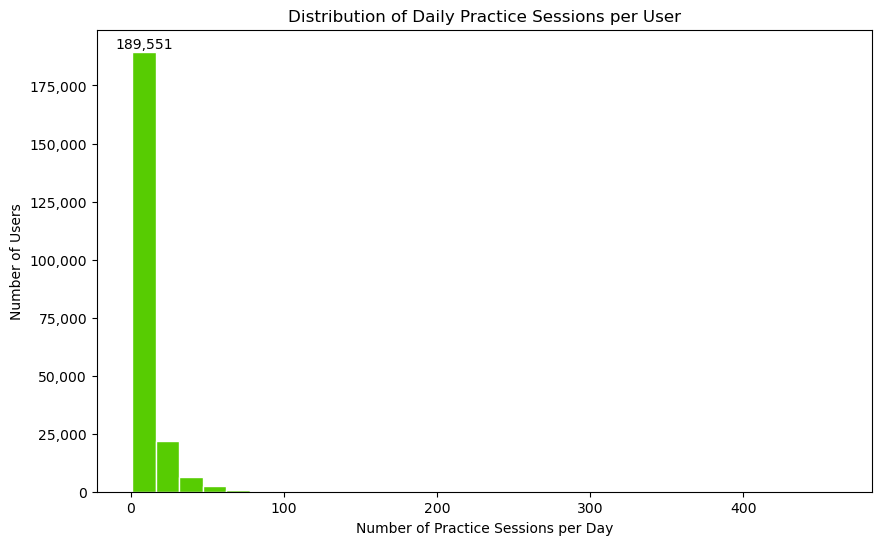


Summary Statistics:
count    221825.000000
mean          9.016116
std          12.839952
min           1.000000
25%           2.000000
50%           5.000000
75%          11.000000
max         461.000000
Name: practice_count, dtype: float64


In [26]:
# Create daily practices per user
daily_practices_per_user = duolingo_users_reduced.groupby(['user_id', 'date'])['timestamp'].count().reset_index()
daily_practices_per_user.columns = ['user_id', 'date', 'practice_count']

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(daily_practices_per_user['practice_count'], 
                           bins=30,  # you can adjust the number of bins
                           color='#57cc02',
                           edgecolor='white')

# Find the maximum height bar
max_count = max(n)
max_bin_index = list(n).index(max_count)
max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

# Add text annotation for the maximum value
plt.text(max_bin_center, max_count, 
         f'{int(max_count):,}', 
         horizontalalignment='center',
         verticalalignment='bottom')

# Add title and labels
plt.title('Distribution of Daily Practice Sessions per User')
plt.xlabel('Number of Practice Sessions per Day')
plt.ylabel('Number of Users')

# Optional: Format y-axis with comma separator for better readability
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Show the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(daily_practices_per_user['practice_count'].describe())

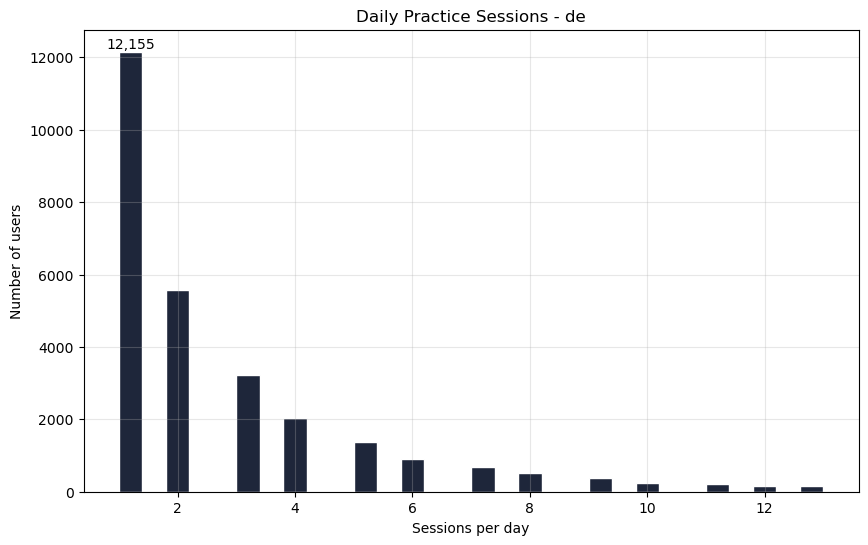

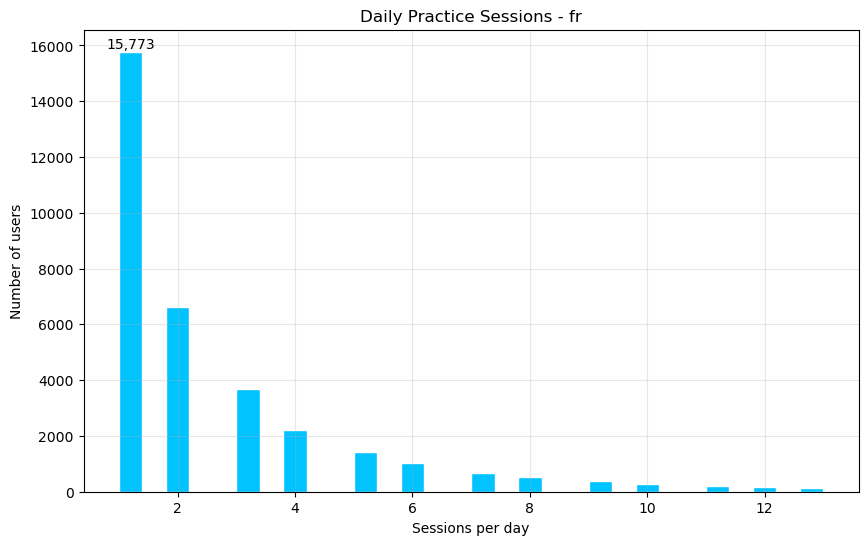

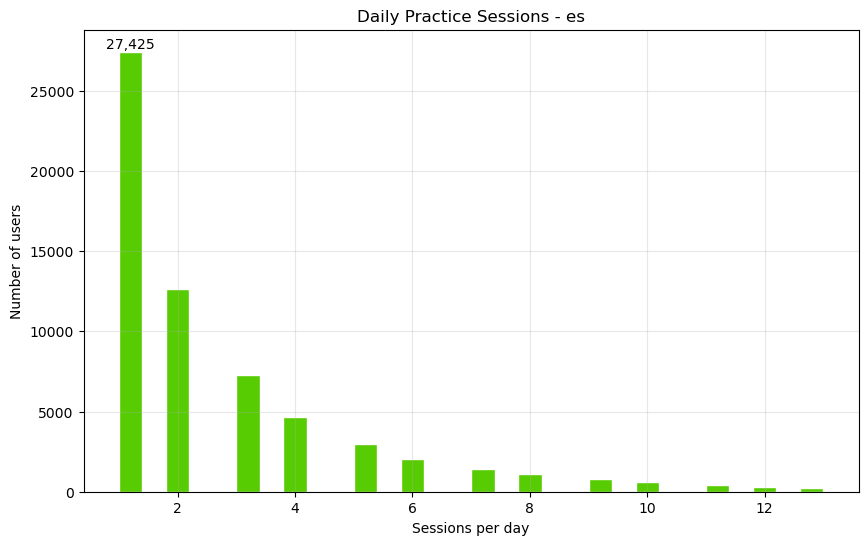

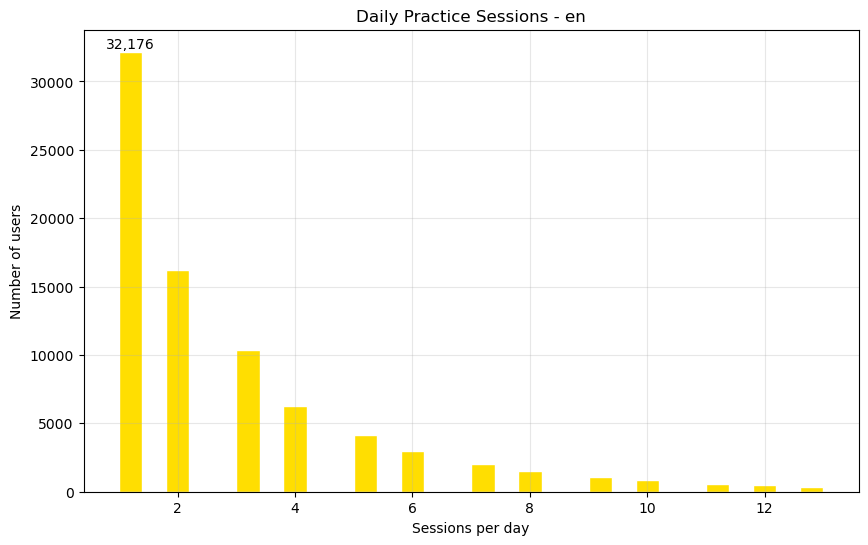

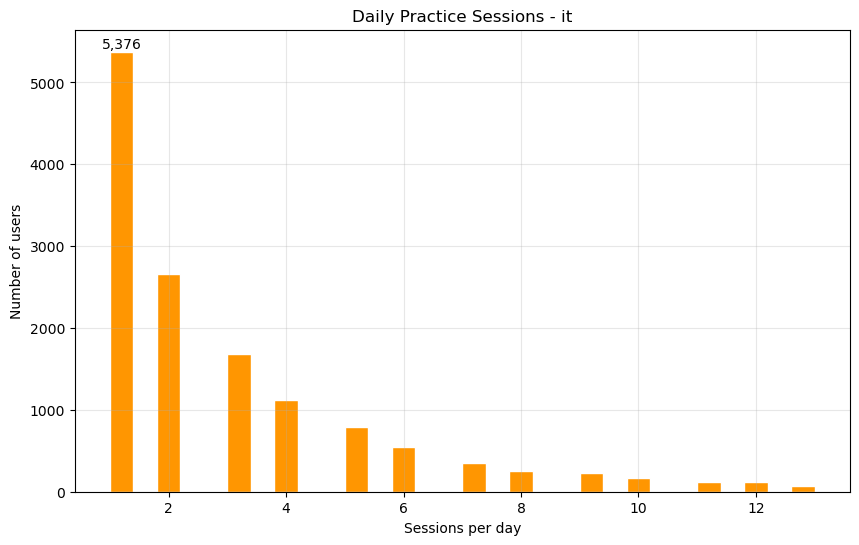

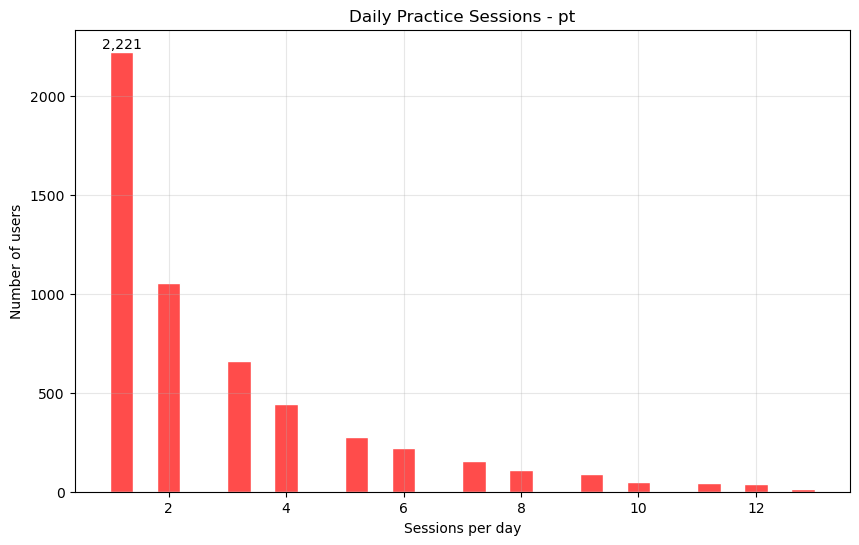


Summary Statistics by Language:
                     count      mean       std  min  25%  50%  75%   max
learning_language                                                       
de                 27604.0  2.696059  2.398087  1.0  1.0  2.0  3.0  13.0
en                 79048.0  2.793923  2.397258  1.0  1.0  2.0  4.0  13.0
es                 61813.0  2.641920  2.323642  1.0  1.0  2.0  3.0  13.0
fr                 33138.0  2.520188  2.272095  1.0  1.0  2.0  3.0  13.0
it                 13480.0  2.916246  2.523874  1.0  1.0  2.0  4.0  13.0
pt                  5369.0  2.818961  2.414022  1.0  1.0  2.0  4.0  13.0


In [27]:
# First, prepare the data
df_aux = duolingo_users_reduced[['user_id', 'learning_language', 'date', 'timestamp']].groupby(by=['user_id', 'learning_language', 'date']).nunique().reset_index()
df_aux.columns = ['user_id', 'learning_language', 'date', 'count_lessons']
df_aux = df_aux[df_aux['count_lessons'] <= df_aux['count_lessons'].quantile(0.975)].copy()

# Colors for each language
colors = ['#1e263a', '#00c3ffff', '#57cc02', '#ffde01ff', '#ff9601ff', '#ff4c4bff']
languages = df_aux['learning_language'].unique()

# Individual histograms for each language
for language, color in zip(languages, colors):
    plt.figure(figsize=(10, 6))
    language_data = df_aux[df_aux['learning_language'] == language]['count_lessons']
    
    # Create histogram
    n, bins, patches = plt.hist(language_data, bins=30, color=color, edgecolor='white')
    
    # Add count on top of highest bar
    max_count = max(n)
    max_bin_index = list(n).index(max_count)
    max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2
    plt.text(max_bin_center, max_count, f'{int(max_count):,}', 
             horizontalalignment='center', verticalalignment='bottom')
    
    plt.title(f"Daily Practice Sessions - {language}")
    plt.xlabel('Sessions per day')
    plt.ylabel('Number of users')
    plt.grid(True, alpha=0.3)
    plt.show()

# Print summary statistics for each language
print("\nSummary Statistics by Language:")
print(df_aux.groupby('learning_language')['count_lessons'].describe())

##### Does the time since the last practice imply a greater probability of a mistake?

In [28]:
#Preparing the database to apply the model
df_aux = duolingo_users_reduced[['user_id', 'lexeme_id', 'session_perfect', 'timestamp']].drop_duplicates()
df_aux.sort_values(by=['user_id', 'timestamp'], ascending=[True,False], inplace=True)
df_aux['previous_session_perfect'] = df_aux.groupby(['user_id', 'lexeme_id'])['session_perfect'].shift(-1)
df_aux['previous_timestamp'] = df_aux.groupby(['user_id', 'lexeme_id'])['timestamp'].shift(-1)
df_aux = df_aux[df_aux['previous_session_perfect'].notna()]
df_aux['diff_hour'] = np.round((df_aux['timestamp']-df_aux['previous_timestamp'])/np.timedelta64(1, 'h')).astype(int)

#Applying Kaplan Meier model for survival analysis
kmf_prev_perf = KaplanMeierFitter()
kmf_prev_miss = KaplanMeierFitter()
df_aux_ = df_aux[df_aux['previous_session_perfect']==True]
kmf_prev_perf.fit(durations = df_aux_['diff_hour'], event_observed = df_aux_['session_perfect'], 
                  label='Perfect previous session')
df_aux_ = df_aux[df_aux['previous_session_perfect']==False]
kmf_prev_miss.fit(durations = df_aux_['diff_hour'], event_observed = df_aux_['session_perfect'], 
                  label='Imperfect previous session')

<lifelines.KaplanMeierFitter:"Imperfect previous session", fitted with 70058 total observations, 16385 right-censored observations>

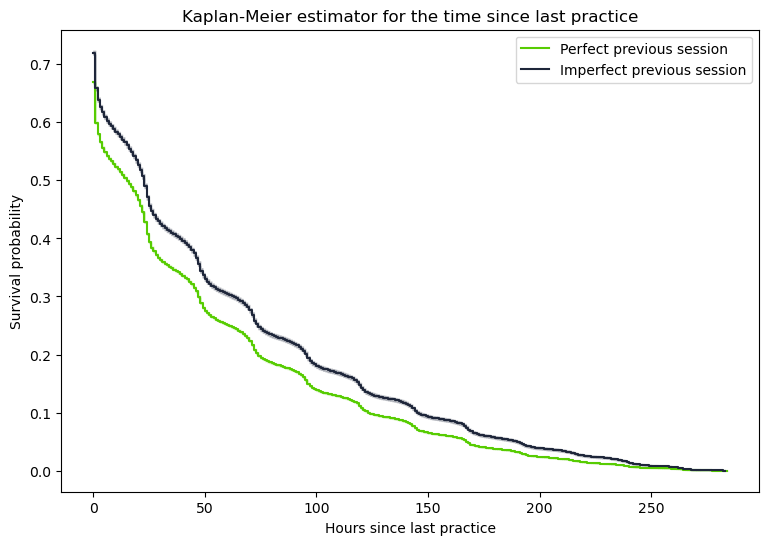

In [29]:
plt.figure(figsize=(9,6))

#Plotting the charts
kmf_prev_perf.plot(color='#57cc02') 
kmf_prev_miss.plot(color='#1e263a') 

#Fancy stuff
plt.title("Kaplan-Meier estimator for the time since last practice") 
plt.xlabel("Hours since last practice") 
plt.ylabel("Survival probability")
plt.show()

In [30]:
print('The median survival time when the last practice was perfect is {}'.format(kmf_prev_perf.median_survival_time_))
print('The median survival time when the last practice was imperfect is {}'.format(kmf_prev_miss.median_survival_time_))

The median survival time when the last practice was perfect is 15.0
The median survival time when the last practice was imperfect is 23.0


In [31]:
duolingo_users_reduced.to_csv("duolingo_users_reduced.csv", index=False)

##### The plot illustrates the Kaplan-Meier survival curves for two groups of users based on their previous practice sessions: those who had a "Perfect previous session" (green line) and those with an "Imperfect previous session" (black line). 

#### Key Observations:

1. **Survival Probability**:
   - The survival probability represents the likelihood that users will continue to practice after a certain number of hours since their last session.
   - Initially, both groups start with a high survival probability, around 0.7, indicating that a significant proportion of users are still engaged shortly after their last practice.

2. **Decline Over Time**:
   - Both curves show a downward trend as time since the last practice increases, indicating that the likelihood of users returning to practice decreases over time.
   - The decline is more pronounced for users with an "Imperfect previous session," suggesting that these users are more likely to disengage compared to those who had a "Perfect previous session."

3. **Comparison Between Groups**:
   - The green line (Perfect previous session) remains higher than the black line (Imperfect previous session) throughout the observed time period. This indicates that users who had a perfect session are more likely to return to practice than those who had an imperfect session.
   - The gap between the two curves widens as time progresses, highlighting the impact of the quality of the previous session on user retention.

4. **Censoring**:
   - The plot does not show any censoring marks, which would indicate users who have not yet churned by the end of the observation period. This suggests that the analysis focuses on users who have completed their sessions.

#### Conclusion:
The Kaplan-Meier estimator plot effectively demonstrates the relationship between the quality of previous practice sessions and user retention over time. Users who have a perfect previous session exhibit higher engagement levels compared to those with an imperfect session. This insight can inform strategies to enhance user experience and retention, such as improving the quality of practice sessions or providing incentives for users who have imperfect sessions to return.

***

##### Conclusions:
Considering this section of the database, I would suggest:

- Develop new marketing campaigns to encourage the learning of less frequent languages such as Portuguese, Italian or German.

- Discover a way to make learning French a little more intuitive and didactic.

- The number of exercises on grammatical conjunctions would increase to strengthen users' learning in this part.

- Focus on strategies to improve user attendance in the “Critical” and “Growing Slowly” periods.

- I would invest in strategies to restore users' daily sequences and would also increase the number of notifications in the app to call users back to the app.

- If weekdays are more common practice days, I would add a participation bonus on weekends.